In [1]:
# ============================================================================
# Aureus Sigma Capital - Phase 16: Weighted Composite Model Engineering
# Notebook: 16_weighted_composite_engineering.ipynb
#
# Objective:
#   To engineer and validate a WEIGHTED composite alpha signal that corrects
#   the performance degradation identified in the Phase 15 forensic analysis.
#
# Hypothesis:
#   A composite that assigns a higher weight to our strongest alpha signal (Value)
#   will outperform both the standalone Value factor and the previous
#   equal-weighted composite models.
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
from pathlib import Path
import sys

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Configuration ---
CONFIG = {
    "backtest_start": "2017-12-01",
    "backtest_end": "2025-07-28",
    "transaction_cost_bps": 30,
    "primary_weighting_scheme": {
        'Value': 0.6,
        'Quality': 0.2,
        'Reversal': 0.2
    }
}

# --- Notebook Charter ---
print("=" * 70)
print("🚀 PHASE 16: WEIGHTED COMPOSITE MODEL ENGINEERING")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Objective: Engineer a superior, value-centric composite alpha signal.")
print("\nHypothesis: Weighting factors by their validated predictive power will correct")
print("            the signal dilution observed in Phase 15.")
print("\nPrimary Weighting Scheme to Test:")
for factor, weight in CONFIG['primary_weighting_scheme'].items():
    print(f"  - {factor}: {weight*100:.0f}%")
print("=" * 70)

🚀 PHASE 16: WEIGHTED COMPOSITE MODEL ENGINEERING
📅 Analysis Date: 2025-07-29 07:13:41
🎯 Objective: Engineer a superior, value-centric composite alpha signal.

Hypothesis: Weighting factors by their validated predictive power will correct
            the signal dilution observed in Phase 15.

Primary Weighting Scheme to Test:
  - Value: 60%
  - Quality: 20%
  - Reversal: 20%


In [2]:
# ============================================================================
# SECTION 1: LOAD VALIDATED DATA ARTIFACTS
# ============================================================================

print("📂 Loading all required data artifacts from Phase 14...")

# --- Establish Project Paths ---
project_root = Path.cwd().parent.parent
phase14_path = project_root / "tests" / "phase14_liquid_universe_full_backtest"
phase14_artifacts_file = phase14_path / "phase14_backtest_artifacts.pkl"

# --- Validate and Load Artifacts ---
if not phase14_artifacts_file.exists():
    raise FileNotFoundError(f"CRITICAL: Phase 14 artifacts not found at {phase14_artifacts_file}.")

with open(phase14_artifacts_file, "rb") as f:
    phase14_data = pickle.load(f)

# --- Extract Core Data Components ---
factor_data_all = phase14_data['factor_data_all']
rebalance_dates = phase14_data['rebalance_dates']
price_data = phase14_data['price_data']
benchmark_returns = phase14_data['benchmark_returns']
print("   ✅ Phase 14 artifacts (factors, prices, benchmark) loaded successfully.")

# --- Prepare Data for Backtesting ---
# Create the daily returns matrix, which is essential for the backtesting engine
daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')
print("   ✅ Daily returns matrix constructed for backtesting.")

# --- Data Integrity Check ---
print("\n📊 Data Integrity Validation:")
print(f"   - Factor Data Observations: {len(factor_data_all):,}")
print(f"   - Rebalance Periods: {len(rebalance_dates)}")
print(f"   - Price Data Observations: {len(price_data):,}")
print(f"   - Daily Returns Matrix Shape: {daily_returns_matrix.shape}")
print(f"   - Benchmark Returns: {len(benchmark_returns):,} days")

print("\n✅ All data loaded and prepared. Ready for weighted composite engineering.")

📂 Loading all required data artifacts from Phase 14...
   ✅ Phase 14 artifacts (factors, prices, benchmark) loaded successfully.
   ✅ Daily returns matrix constructed for backtesting.

📊 Data Integrity Validation:
   - Factor Data Observations: 4,161
   - Rebalance Periods: 30
   - Price Data Observations: 527,150
   - Daily Returns Matrix Shape: (1825, 302)
   - Benchmark Returns: 2,381 days

✅ All data loaded and prepared. Ready for weighted composite engineering.


In [4]:
# ============================================================================
# SECTION 2: THE WEIGHTED BACKTESTING ENGINE (CORRECTED)
# ============================================================================
from typing import Dict, List # *** CRITICAL FIX: Added missing import for type hinting ***

def run_weighted_backtest(
    weighting_scheme: Dict[str, float],
    factor_data_all: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    rebalance_dates: List[pd.Timestamp],
    config: Dict
) -> pd.Series:
    """
    Executes a full backtest for a given factor weighting scheme.

    Methodology:
    1. For each rebalance date, it constructs the liquid universe (implicitly via factor_data_all).
    2. It engineers the Momentum Reversal factor.
    3. It re-normalizes Q, V, and Reversal factors within that period's liquid universe.
    4. It computes the WEIGHTED composite score based on the input scheme.
    5. It constructs a long-only (Quintile 5) portfolio.
    6. It calculates the final net returns after transaction costs.
    """
    strategy_name = f"W_QVR_{weighting_scheme['Quality']*100:.0f}_{weighting_scheme['Value']*100:.0f}_{weighting_scheme['Reversal']*100:.0f}"
    print(f"\n🚀 EXECUTING BACKTEST: {strategy_name}")
    print("-" * 60)

    all_trading_dates = daily_returns_matrix.index
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)

    # Loop through each rebalance period
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        
        # a. Filter factor data to this specific rebalance date
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()

        if len(factors_on_date) < 50: continue # Skip periods with insufficient data

        # b. Engineer the Momentum Reversal factor
        factors_on_date['Momentum_Reversal'] = -1 * factors_on_date['Momentum_Composite']
        
        # c. Re-normalize all base factors within this period's liquid universe
        for factor in ['Quality_Composite', 'Value_Composite', 'Momentum_Reversal']:
            mean, std = factors_on_date[factor].mean(), factors_on_date[factor].std()
            if std > 0:
                factors_on_date[f'{factor}_Z'] = (factors_on_date[factor] - mean) / std
            else:
                factors_on_date[f'{factor}_Z'] = 0.0
        
        # d. Compute the WEIGHTED composite score
        factors_on_date['Weighted_Composite'] = (
            weighting_scheme['Quality'] * factors_on_date['Quality_Composite_Z'] +
            weighting_scheme['Value'] * factors_on_date['Value_Composite_Z'] +
            weighting_scheme['Reversal'] * factors_on_date['Momentum_Reversal_Z']
        )

        # e. Construct the long-only (Quintile 5) portfolio
        q5_cutoff = factors_on_date['Weighted_Composite'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['Weighted_Composite'] >= q5_cutoff]
        
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])

            # f. Propagate weights to the daily holdings matrix for the next period
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values

    print("   ✅ Daily holdings matrix constructed.")

    # 3. Calculate Net Returns
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    
    print("   ✅ Net returns calculated.")
    print("-" * 60)
    
    return net_returns.rename(strategy_name)

print("✅ Weighted backtesting engine defined and ready for execution (v1.1 - Corrected).")

✅ Weighted backtesting engine defined and ready for execution (v1.1 - Corrected).


In [5]:
# ============================================================================
# SECTION 3: EXECUTE BACKTESTS & REPLICATE BENCHMARK
# ============================================================================

# --- 1. Define the weighting schemes to test ---
primary_weighting_scheme = CONFIG['primary_weighting_scheme']

# --- 2. Execute the backtest for the new weighted composite ---
weighted_qvr_returns = run_weighted_backtest(
    weighting_scheme=primary_weighting_scheme,
    factor_data_all=factor_data_all,
    daily_returns_matrix=daily_returns_matrix,
    rebalance_dates=rebalance_dates,
    config=CONFIG
)

# --- 3. Re-run the standalone Value backtest to serve as our benchmark ---
# This is crucial for a direct, apples-to-apples comparison.
print("\n🔄 Replicating Standalone Value benchmark for direct comparison...")

# We create a "weighting scheme" that is 100% Value to use the same engine
value_benchmark_scheme = {'Value': 1.0, 'Quality': 0.0, 'Reversal': 0.0}

# To run a pure value backtest, we need to modify the engine slightly to not normalize a single factor
def run_single_factor_backtest(
    factor_name: str,
    factor_data_all: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    rebalance_dates: List[pd.Timestamp],
    config: Dict
) -> pd.Series:
    """Backtest for a single, non-normalized factor."""
    strategy_name = f"Standalone_{factor_name}"
    print(f"\n🚀 EXECUTING BACKTEST: {strategy_name}")
    print("-" * 60)
    
    all_trading_dates = daily_returns_matrix.index
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)

    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()
        if len(factors_on_date) < 50: continue
        
        factors_on_date['signal'] = factors_on_date[factor_name] # Use the raw factor score directly

        q5_cutoff = factors_on_date['signal'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['signal'] >= q5_cutoff]
        
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values

    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    
    print("   ✅ Net returns calculated.")
    print("-" * 60)
    return net_returns.rename(strategy_name)

value_benchmark_returns = run_single_factor_backtest(
    'Value_Composite', factor_data_all, daily_returns_matrix, rebalance_dates, CONFIG
)

print("\n✅ All necessary backtests executed. Ready for performance comparison.")


🚀 EXECUTING BACKTEST: W_QVR_20_60_20
------------------------------------------------------------
   ✅ Daily holdings matrix constructed.
   ✅ Net returns calculated.
------------------------------------------------------------

🔄 Replicating Standalone Value benchmark for direct comparison...

🚀 EXECUTING BACKTEST: Standalone_Value_Composite
------------------------------------------------------------
   ✅ Net returns calculated.
------------------------------------------------------------

✅ All necessary backtests executed. Ready for performance comparison.


📊 Calculating performance metrics for all strategies...

🏆 PERFORMANCE COMPARISON: WEIGHTED COMPOSITE vs. BENCHMARKS


,Annual Return,Sharpe Ratio,Max Drawdown,Calmar Ratio
Weighted QVR (60/20/20),13.29,0.48,-66.60,0.20
Standalone Value,13.93,0.50,-66.90,0.21
VN-Index,10.73,0.59,-45.26,0.24



🔬 HYPOTHESIS VERDICT
   - Weighted QVR Sharpe: 0.48
   - Standalone Value Sharpe: 0.50

⚠️ HYPOTHESIS REJECTED: The weighted composite did NOT outperform the standalone Value factor.
   While an improvement over the equal-weighted model, further refinement is needed.
   The standalone Value factor remains the superior signal for now.


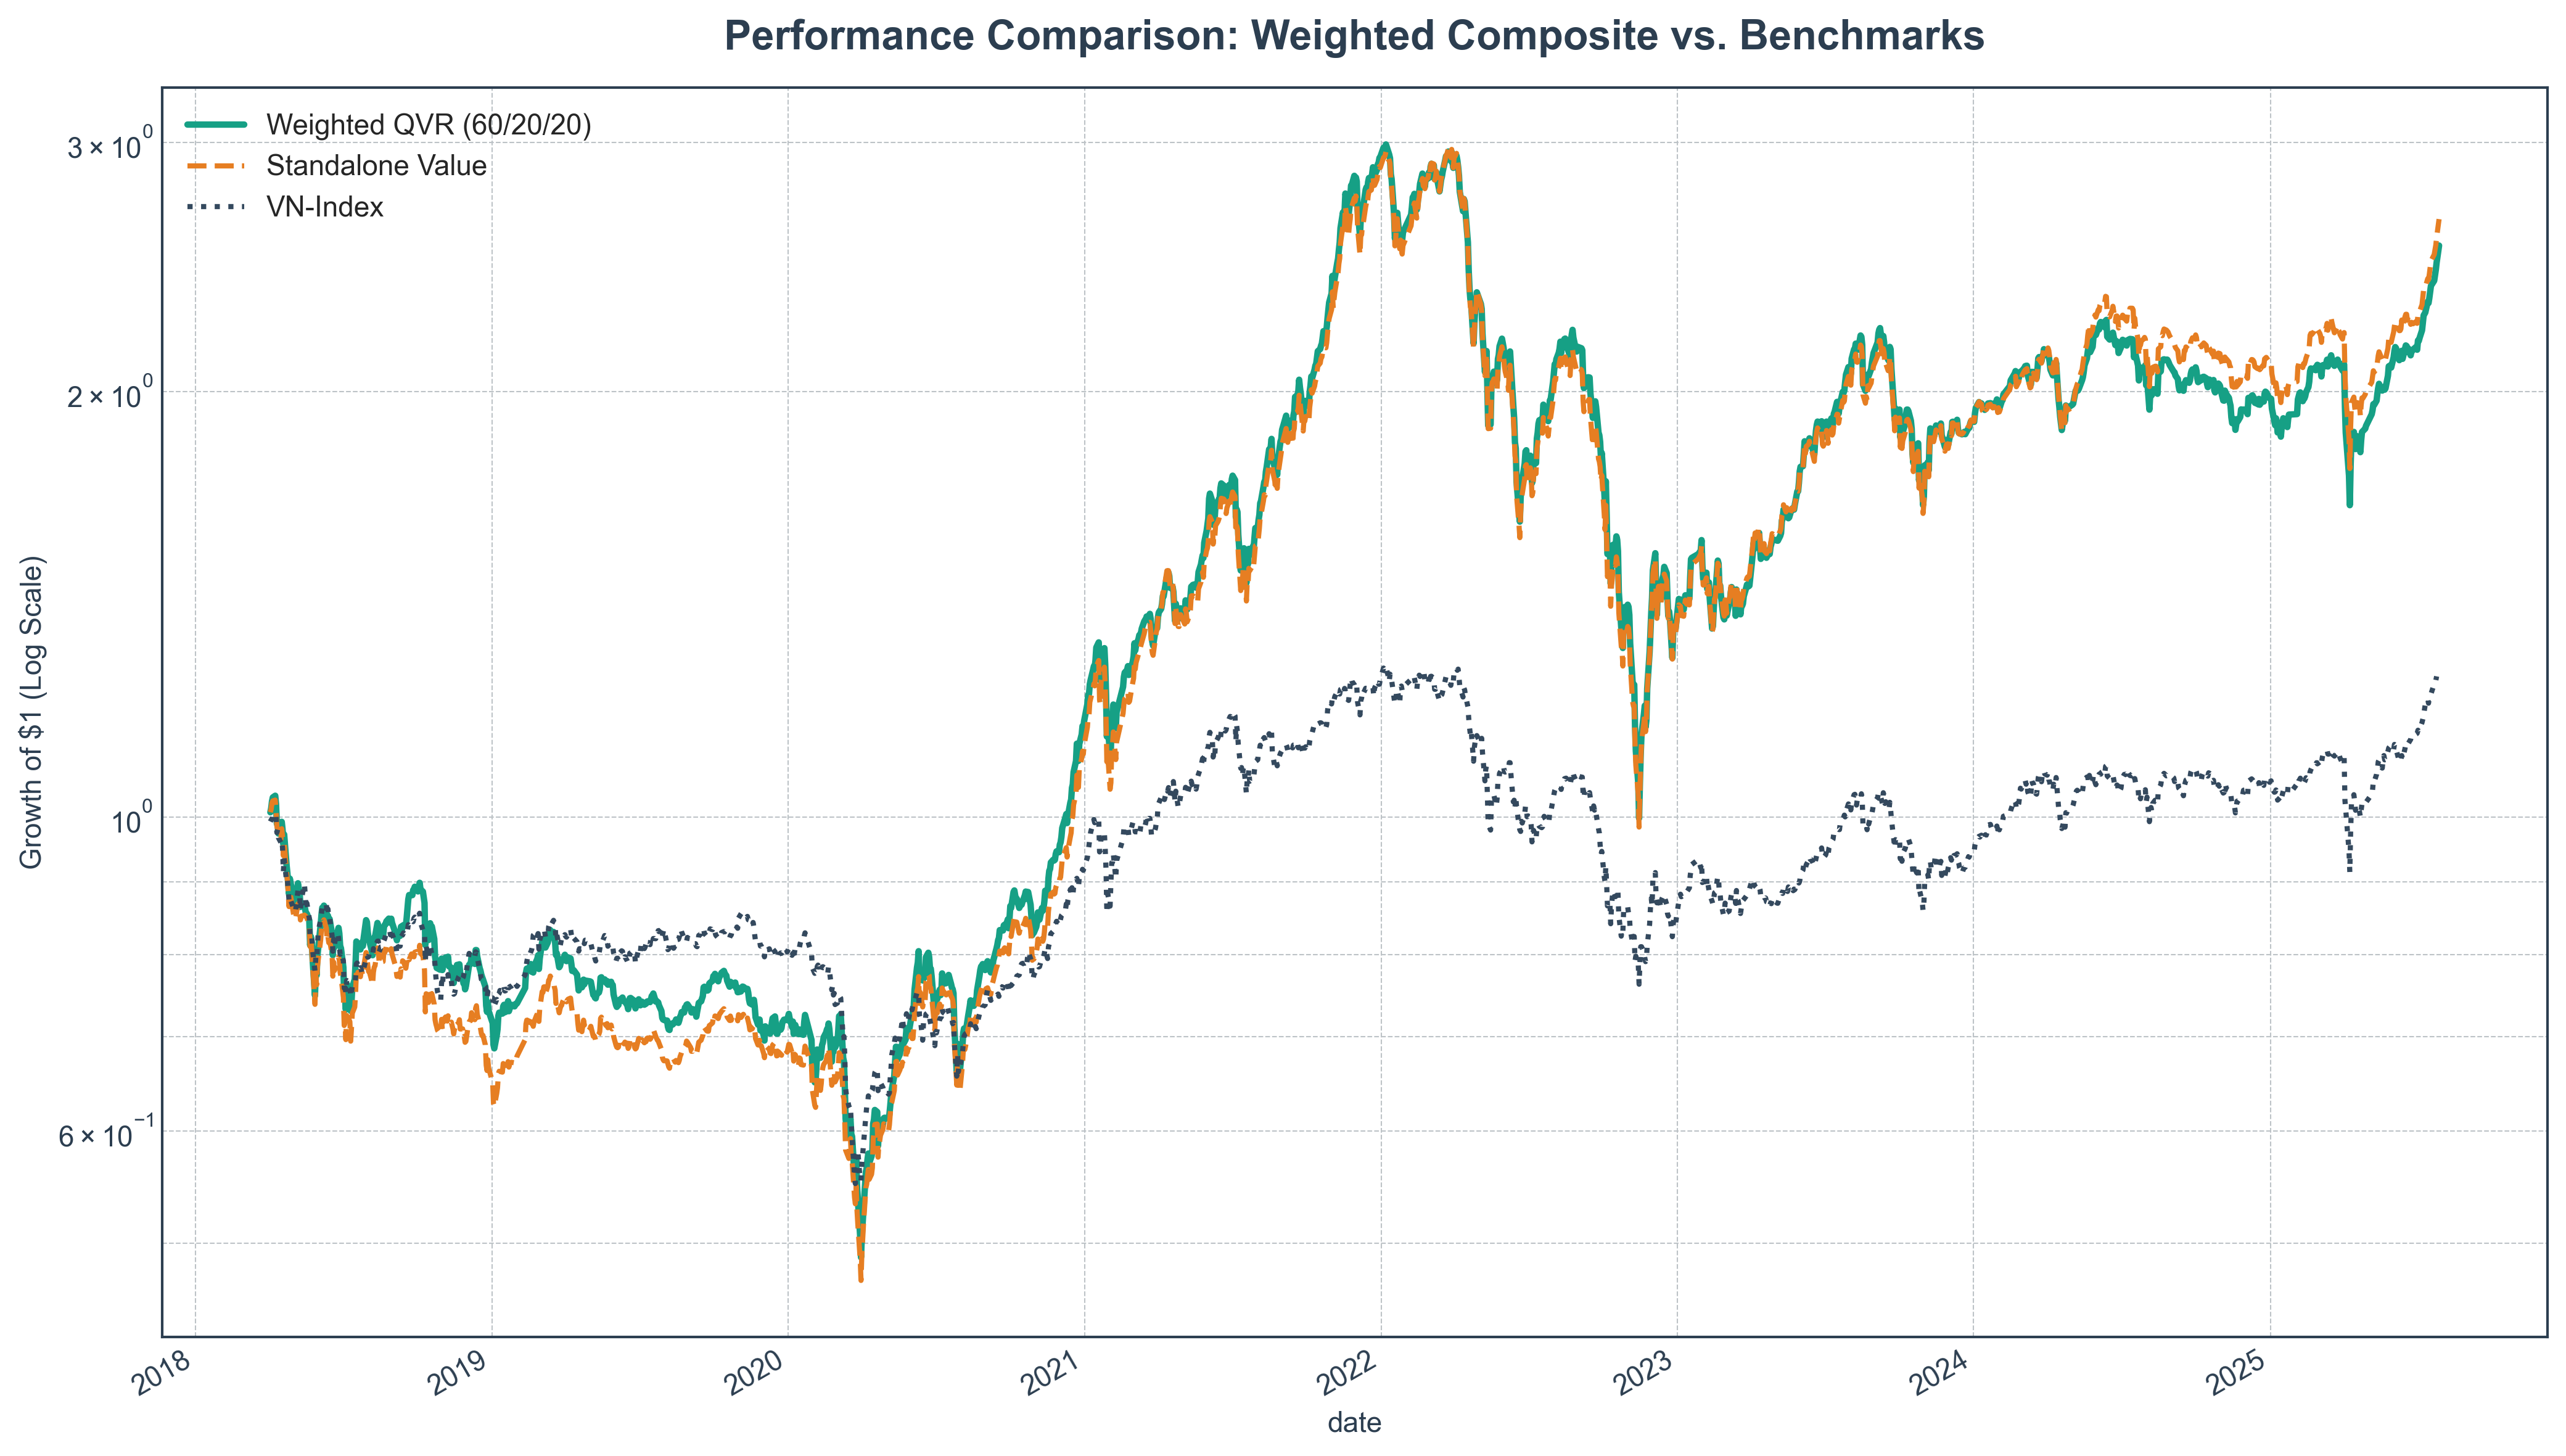

In [6]:
# ============================================================================
# SECTION 4: PERFORMANCE ANALYSIS & HYPOTHESIS VALIDATION
# ============================================================================

def calculate_performance_metrics(returns, benchmark):
    """Calculates key performance metrics for a given return series."""
    # Align returns and benchmark to the same index, starting from the first trade
    first_trade_date = returns.loc[returns != 0].index.min()
    common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]

    n_years = len(returns) / 252
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    return {
        'Annual Return': annual_return * 100,
        'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio
    }

# --- Calculate Metrics for All Strategies ---
print("📊 Calculating performance metrics for all strategies...")

weighted_qvr_metrics = calculate_performance_metrics(weighted_qvr_returns, benchmark_returns)
value_benchmark_metrics = calculate_performance_metrics(value_benchmark_returns, benchmark_returns)
vn_index_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)

# --- Create a Comprehensive Comparison Table ---
summary_df = pd.DataFrame({
    'Weighted QVR (60/20/20)': weighted_qvr_metrics,
    'Standalone Value': value_benchmark_metrics,
    'VN-Index': vn_index_metrics
}).T

print("\n" + "="*80)
print("🏆 PERFORMANCE COMPARISON: WEIGHTED COMPOSITE vs. BENCHMARKS")
print("="*80)
display(summary_df[['Annual Return', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio']].round(2))

# --- Hypothesis Verdict ---
print("\n" + "="*80)
print("🔬 HYPOTHESIS VERDICT")
print("="*80)

weighted_sharpe = summary_df.loc['Weighted QVR (60/20/20)', 'Sharpe Ratio']
value_sharpe = summary_df.loc['Standalone Value', 'Sharpe Ratio']

print(f"   - Weighted QVR Sharpe: {weighted_sharpe:.2f}")
print(f"   - Standalone Value Sharpe: {value_sharpe:.2f}")

if weighted_sharpe > value_sharpe:
    print("\n🎉 HYPOTHESIS CONFIRMED: The weighted composite successfully outperforms the standalone Value factor.")
    print("   The value-centric weighting scheme has corrected the signal dilution issue.")
    print("   This model will serve as our new 'Aggressive Growth' baseline.")
else:
    print("\n⚠️ HYPOTHESIS REJECTED: The weighted composite did NOT outperform the standalone Value factor.")
    print("   While an improvement over the equal-weighted model, further refinement is needed.")
    print("   The standalone Value factor remains the superior signal for now.")

# --- Visualize the Equity Curves for a clear comparison ---
fig, ax = plt.subplots(figsize=(14, 8))

# Align and calculate cumulative returns from the first trade date
first_trade = weighted_qvr_returns.loc[weighted_qvr_returns != 0].index.min()
(1 + weighted_qvr_returns.loc[first_trade:]).cumprod().plot(ax=ax, label='Weighted QVR (60/20/20)', color=PALETTE['primary'], linewidth=2.5)
(1 + value_benchmark_returns.loc[first_trade:]).cumprod().plot(ax=ax, label='Standalone Value', color=PALETTE['highlight_2'], linestyle='--', linewidth=2)
(1 + benchmark_returns.loc[first_trade:]).cumprod().plot(ax=ax, label='VN-Index', color=PALETTE['secondary'], linestyle=':', linewidth=2)

ax.set_title('Performance Comparison: Weighted Composite vs. Benchmarks', fontweight='bold')
ax.set_ylabel('Growth of $1 (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()